In [1]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt 
import copy
import timeit
import time
import subprocess
import pickle
from gurobipy import Model, GRB

In [2]:
import os
def plotp (m):
    data=m[::-1,:]
    heatmap = plt.pcolor(data, cmap=plt.cm.tab20, edgecolors='grey', linewidths=2)
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            plt.text(x + 0.5, y + 0.5, '%.0f' % data[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.show()
def start(w,h):
    arr = np.zeros(w*h,dtype=int) 
    arr[:random.randrange(0, w*h+1)]  = 1
    np.random.shuffle(arr)
    g = np.reshape(arr,(w,h))
    return g
g=start(5,5)

In [3]:
def balancednessDetection(field):
    field = np.array(field)  # Ensure field is a numpy array for efficient operations

    def rectangleRecognition(field):
        rows, cols = field.shape
        for i in range(rows - 1):
            for j in range(cols - 1):
                if field[i, j] > 0:
                    if field[i + 1, j] > 0 and field[i, j + 1] > 0 and field[i + 1, j + 1] > 0:
                        if (i + 2 < rows and field[i + 2, j] > 0 and field[i + 2, j + 1] > 0) or \
                           (j + 2 < cols and field[i, j + 2] > 0 and field[i + 1, j + 2] > 0):
                            return True
        return False

    def squaresRecognition(field):
        rows, cols = field.shape
        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                if field[i, j] == 1 and \
                   field[i, j - 1] == 1 and field[i - 1, j] == 1 and \
                   field[i + 1, j] == 1 and field[i, j + 1] == 1:
                    if (field[i - 1, j + 1] == 1 and field[i + 1, j - 1] == 1) or \
                       (field[i - 1, j - 1] == 1 and field[i + 1, j + 1] == 1):
                        return True
        return False

    def cycles(field):
        pixels = set(zip(*np.where(field == 1)))
        rows, cols = field.shape

        def get_neighbors(x, y):
            neighbors = []
            if x > 0 and field[x - 1, y] == 1:
                neighbors.append((x - 1, y))
            if x < rows - 1 and field[x + 1, y] == 1:
                neighbors.append((x + 1, y))
            if y > 0 and field[x, y - 1] == 1:
                neighbors.append((x, y - 1))
            if y < cols - 1 and field[x, y + 1] == 1:
                neighbors.append((x, y + 1))
            return neighbors

        while pixels:
            root = pixels.pop()
            stack = [root]
            pred = {root: root}
            used = {root: set()}

            while stack:
                z = stack.pop()
                zused = used[z]
                i, j = z
                neighbors = get_neighbors(i, j)

                for nb in neighbors:
                    if nb not in used:
                        pred[nb] = z
                        stack.append(nb)
                        used[nb] = {z}
                    elif nb == z:
                        continue
                    elif nb not in zused:
                        pn = used[nb]
                        cycle = [nb, z]
                        p = pred[z]
                        while p not in pn:
                            cycle.append(p)
                            p = pred[p]
                        cycle.append(p)
                        if len(cycle) > 4:
                            return True
                        used[nb].add(z)
            pixels -= set(pred)
        return False

    if rectangleRecognition(field) and squaresRecognition(field) and cycles(field):
        return False
    else:
        return True

# Example usage
g = [
    [1, 1, 0, 0],
    [1, 1, 1, 0],
    [0, 1, 1, 1],
    [0, 0, 1, 1]
]
result = balancednessDetection(g)
print(f"Is the field balanced? {result}")


Is the field balanced? True


In [4]:
def ip(field):
    width, height = len(field), len(field[0])
    all_rectangles = []
    rectangles = [[[] for _ in range(height)] for _ in range(width)]

    # Identify all possible rectangles
    for start_row in range(width):
        for start_col in range(height):
            if field[start_row][start_col] != 0:
                max_col = height
                for end_row in range(start_row, width):
                    for end_col in range(start_col, max_col):
                        if field[end_row][end_col] == 0:
                            max_col = end_col
                            break
                        for fill_row in range(start_row, end_row + 1):
                            for fill_col in range(start_col, end_col + 1):
                                if not rectangles[fill_row][fill_col] or rectangles[fill_row][fill_col][-1] != (start_row, start_col, end_row, end_col):
                                    rectangles[fill_row][fill_col].append((start_row, start_col, end_row, end_col))
                        all_rectangles.append((start_row, start_col, end_row, end_col))

    # Set up optimization model
    model = Model()
    #model.Params.OutputFlag = 0

    rect_vars = model.addVars(all_rectangles, vtype=GRB.BINARY, name='Rectangles')

    for row in range(width):
        for col in range(height):
            if field[row][col] != 0:
                model.addConstr(sum(rect_vars[rect] for rect in rectangles[row][col]) == 1)

    model.setObjective(
        sum(rect_vars[rect] * ((rect[2] - rect[0] + 1) ** 2) * ((rect[3] - rect[1] + 1) ** 2) for rect in all_rectangles),
        GRB.MAXIMIZE
    )

    model.Params.Heuristics = 0
    model.Params.Presolve = 0
    model.optimize()

    if model.status == GRB.OPTIMAL:
        return model.objVal, model.runtime
    else:
        return None

# Example usage with a sample field 'g'
g = [
    [1, 1, 0, 0],
    [1, 1, 1, 0],
    [0, 1, 1, 1],
    [0, 0, 1, 1]
]
result = ip(g)
print(f"Optimized objective value: {result}")


Set parameter Heuristics to value 0
Set parameter Presolve to value 0
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10 rows, 29 columns and 58 nonzeros
Model fingerprint: 0x4b37b11f
Variable types: 0 continuous, 29 integer (29 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Variable types: 0 continuous, 29 integer (29 binary)

Root relaxation: objective 3.400000e+01, 10 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      34.0000000   34.00000  0.00%     -    0s

Explored 1 nodes (10 simplex iteration

In [5]:
def ip_advanced(field):
    width, height = len(field), len(field[0])
    all_rectangles = []
    rectangles = [[[] for _ in range(height)] for _ in range(width)]
    intersecting_rectangles = {}

    # Identify all possible rectangles
    for start_row in range(width):
        for start_col in range(height):
            if field[start_row][start_col] != 0:
                max_col = height
                for end_row in range(start_row, width):
                    for end_col in range(start_col, max_col):
                        if field[end_row][end_col] == 0:
                            max_col = end_col
                            break
                        for fill_row in range(start_row, end_row + 1):
                            for fill_col in range(start_col, end_col + 1):
                                if not rectangles[fill_row][fill_col] or rectangles[fill_row][fill_col][-1] != (start_row, start_col, end_row, end_col):
                                    rectangles[fill_row][fill_col].append((start_row, start_col, end_row, end_col))
                        new_rectangle = (start_row, start_col, end_row, end_col)
                        all_rectangles.append(new_rectangle)
                        intersecting_rectangles[new_rectangle] = []

    # Find intersecting rectangles
    for rect1 in all_rectangles:
        for rect2 in all_rectangles:
            if rect1 != rect2:
                if not (rect1[2] < rect2[0] or rect1[0] > rect2[2] or rect1[3] < rect2[1] or rect1[1] > rect2[3]):
                    intersecting_rectangles[rect1].append(rect2)

    # Set up optimization model
    model = Model()
    #model.Params.OutputFlag = 0

    rect_vars = model.addVars(all_rectangles, vtype=GRB.BINARY, name='Rectangles')

    for row in range(width):
        for col in range(height):
            if field[row][col] != 0:
                model.addConstr(sum(rect_vars[rect] for rect in rectangles[row][col]) == 1)

    # generalized idea of adding all cuts
    for rect1 in all_rectangles:
        model.addConstr(len(intersecting_rectangles[rect1]) * rect_vars[rect1] + sum(rect_vars[rect2] for rect2 in intersecting_rectangles[rect1]) <= len(intersecting_rectangles[rect1]))

    # adding cuts regarding the 1x3 or 3x1 rectangle
    '''
    for rect in all_rectangles:
        if (rect[2] - rect[0] + 1 == 3 and rect[3] - rect[1] + 1 == 1) or (rect[2] - rect[0] + 1 == 1 and rect[3] - rect[1] + 1 == 3):
            start_row, start_col, end_row, end_col = rect
            potential_rects = []
            
            if end_row - start_row + 1 == 3:  # 3x1 rectangle
                if start_col > 0:  # check left
                    if all(field[r][start_col - 1] != 0 for r in range(start_row, end_row + 1)):
                        potential_rects.append((start_row, start_col - 1, end_row, start_col - 1))
                        potential_rects.append((start_row + 1, start_col - 1, end_row, start_col - 1))
                        potential_rects.append((start_row + 2, start_col - 1, end_row, start_col - 1))
                if end_col < height - 1:  # check right
                    if all(field[r][end_col + 1] != 0 for r in range(start_row, end_row + 1)):
                        potential_rects.append((start_row, end_col + 1, end_row, end_col + 1))
                        potential_rects.append((start_row +1 , end_col + 1, end_row, end_col + 1))
                        potential_rects.append((start_row + 2, end_col + 1, end_row, end_col + 1))
            
            if end_col - start_col + 1 == 3:  # 1x3 rectangle
                if start_row > 0:  # check above
                    if all(field[start_row - 1][c] != 0 for c in range(start_col, end_col + 1)):
                        potential_rects.append((start_row - 1, start_col, start_row - 1, end_col))
                        potential_rects.append((start_row - 1, start_col +1, start_row - 1, end_col))
                        potential_rects.append((start_row - 1, start_col + 2, start_row - 1, end_col))                
                if end_row < width - 1:  # check below
                    if all(field[end_row + 1][c] != 0 for c in range(start_col, end_col + 1)):
                        potential_rects.append((end_row + 1, start_col, end_row + 1, end_col))
                        potential_rects.append((end_row + 1, start_col +1, end_row + 1, end_col))   
                        potential_rects.append((end_row + 1, start_col +2, end_row + 1, end_col))                        
            

            if len(potential_rects) == 3:
                model.addConstr(3 * rect_vars[rect] + sum(rect_vars[r] for r in potential_rects[:3]) <= 3)
    '''

    model.setObjective(
        sum(rect_vars[rect] * ((rect[2] - rect[0] + 1) ** 2) * ((rect[3] - rect[1] + 1) ** 2) for rect in all_rectangles),
        GRB.MAXIMIZE
    )

    model.Params.Heuristics = 0
    #model.Params.Presolve = 0
    model.optimize()

    if model.status == GRB.OPTIMAL:
        return model.objVal, model.runtime
    else:
        return None

# Example usage with a sample field 'g'
g = [
    [1, 1, 1, 0],
    [1, 1, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 1]
]
result = ip_advanced(g)
print(f"Optimized objective value: {result}")


Set parameter Heuristics to value 0
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 32 rows, 23 columns and 244 nonzeros
Model fingerprint: 0xfba08883
Variable types: 0 continuous, 23 integer (23 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 26 rows and 11 columns
Presolve time: 0.00s
Presolved: 6 rows, 12 columns, 34 nonzeros
Variable types: 0 continuous, 12 integer (12 binary)

Root relaxation: objective 4.100000e+01, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      41.0000000

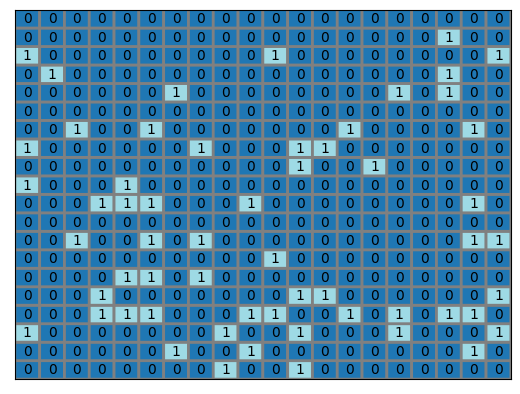

Set parameter Heuristics to value 0
Set parameter Presolve to value 0
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 58 rows, 75 columns and 94 nonzeros
Model fingerprint: 0x67811971
Variable types: 0 continuous, 75 integer (75 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Variable types: 0 continuous, 75 integer (75 binary)

Root relaxation: objective 8.600000e+01, 24 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      86.0000000   86.00000  0.00%     -    0s

Explored 1 nodes (24 simplex iteration

In [6]:
g = start(20,20)
plotp(g)
print(ip(g))
print(ip_advanced(g))